# Analysis of FCS data
## Ste20-GFP, Cdc24-GFP, and Bem1-GFP are measured in A.p. and S.c.

In [24]:
import fcsfiles as fcs # Small one-man repo, likely has bugs
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import inspect

In [25]:
def fcs_extract(data, replicates=range(0,10)):
    times_counts = data['FcsData']['FcsEntry'][0]['FcsDataSet']['CountRateArray'][:,0]
    times_corr = data['FcsData']['FcsEntry'][0]['FcsDataSet']['CorrelationArray'][:,0]
    bins_hist = data['FcsData']['FcsEntry'][0]['FcsDataSet']["PhotonCountHistogramArray"][:,0]
    for i in replicates:
        tmp_bins_hist = data['FcsData']['FcsEntry'][i]['FcsDataSet']["PhotonCountHistogramArray"][:,0]
        if tmp_bins_hist.shape[0] > bins_hist.shape[0]:
            bins_hist = tmp_bins_hist
    all_counts = np.zeros((len(times_counts), len(replicates)))
    all_corr = np.zeros((len(times_corr), len(replicates)))
    sum_hist = np.zeros(len(bins_hist))
    for n, i in enumerate(replicates):
        all_counts[:,n] = data['FcsData']['FcsEntry'][i]['FcsDataSet']['CountRateArray'][:,1]
        all_corr[:,n] = data['FcsData']['FcsEntry'][i]['FcsDataSet']['CorrelationArray'][:,1]
        vals_to_add = data['FcsData']['FcsEntry'][i]['FcsDataSet']['PhotonCountHistogramArray'][:,1]
        sum_hist[0:len(vals_to_add)] += vals_to_add
    mean_corr = np.mean(all_corr, axis=1)
    return times_counts, all_counts, times_corr, all_corr, mean_corr, bins_hist, sum_hist

In [26]:
def plot3(times_counts, all_counts, times_corr, all_corr, mean_corr, bins_hist, sum_hist):
    fig, axs = plt.subplots(3, 1, figsize=(8,8))
    fig.suptitle(f'FCS Data: {data["FcsData"]["Name"]}')
    axs[0].stairs(sum_hist, np.insert(bins_hist, 0, 0));
    axs[0].set_title("Photon Count Histogram (PCH)")
    axs[1].plot(times_counts, all_counts, alpha=0.2);
    axs[1].plot(times_counts, all_counts[:,0], linewidth=0.8, color="C0");
    axs[1].set_title("Fluoresence Trace")
    axs[2].set_xscale("log")
    mean_corr = np.mean(all_corr, axis=1)
    axs[2].plot(times_corr, all_corr, alpha=0.1)
    axs[2].plot(times_corr, mean_corr, linewidth=3, color="C0")
    axs[2].set_title("Correlation Curve")
    fig.tight_layout()

In [27]:
data = fcs.ConfoCor3Fcs('2024_02_01-FCS/atto488_2nM_0p2laser-postCorrect.fcs')

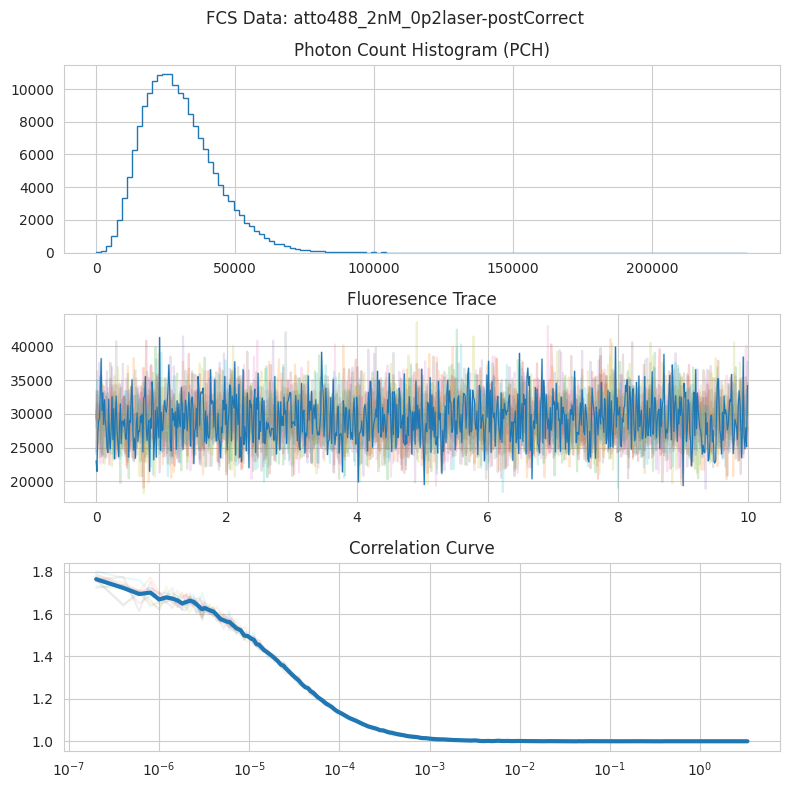

In [28]:
times_counts, all_counts, times_corr, all_corr, mean_corr, bins_hist, sum_hist = fcs_extract(data)
plot3(times_counts, all_counts, times_corr, all_corr, mean_corr, bins_hist, sum_hist)

In [36]:
def plot_fit(xdata, ydata, f, text="2nM atto488 at 0.2% laser power", bounds=(0,100)):
    fit = curve_fit(f, xdata, ydata, bounds=bounds)
    popt, pcov = fit
    perr = np.sqrt(np.diag(pcov))
    fig, axs = plt.subplots(2, 1, figsize=(8,8))
    axs[0].plot(xdata, f(xdata, *popt))
    axs[0].set_xscale("log")
    axs[0].plot(xdata, ydata, color="C03")
    axs[0].set_title(f"{text}")
    residuals = ydata - f(xdata, *popt)
    axs[1].plot(xdata, residuals, color="C03")
    axs[1].set_xscale("log")
    axs[1].set_title(f"Residuals")
    print(popt)

In [49]:
def f(tau, N, tauD):
    k=4.1
    return 1 + (1/N) * (1/(1+tau/tauD)) * (1/(1+(tau/tauD)*(k**2)))**0.5
def f_triplet(tau, N, tauD, k, tauT):
    return 1 + (1/N) * (1/(1+tau/tauD)) * (1/(1+(tau/tauD)*(k**2)))**0.5 * (1-tau+tau*np.e**(-tau/tauT))
def f_anomalous(tau, N, tauD, k, alpha):
    return 1 + (1/N) * (1/(1+(tau/tauD)**alpha)) * (1/(1+((tau/tauD)**alpha)*(k**2)))**0.5
def two_comp(tau, N, tauD1, tauD2, F1, Q1, Q2):
    g1 = (1/(1+tau/tauD1)) * (1/(1+(tau/tauD1)*(4.2**2)))**0.5
    g2 = (1/(1+tau/tauD2)) * (1/(1+(tau/tauD2)*(4.2**2)))**0.5
    G = 1+ ((Q1**2)*F1*g1 + (Q2**2)*(1-F1)*g2) / (N*((Q1*F1 + Q2*(1-F1))**2))
    return G

[1.36929373e+00 1.70307519e-04]


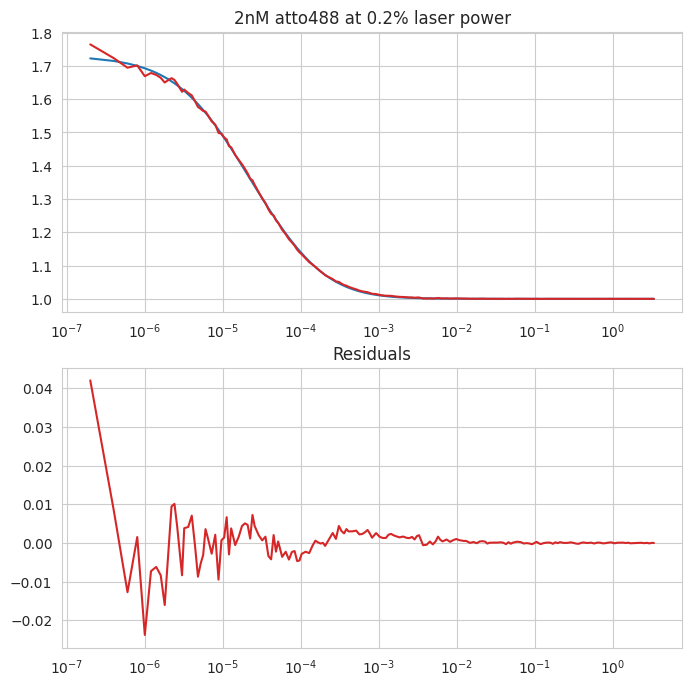

In [37]:
plot_fit(times_corr, mean_corr, f, p0=[1.5, 0.0001])

/tmp/ipykernel_19339/1691283193.py:9: RuntimeWarning: invalid value encountered in sqrt
  g1 = (1/(1+tau/tauD1)) * (1/(1+(tau/tauD1)*(4.2**2)))**0.5
/tmp/ipykernel_19339/1691283193.py:10: RuntimeWarning: invalid value encountered in sqrt
  g2 = (1/(1+tau/tauD2)) * (1/(1+(tau/tauD2)*(4.2**2)))**0.5


[1.30036587e+00 1.75639679e-04 1.75642338e-04 1.20406376e+00
 7.97005402e-01 1.12325581e+00]


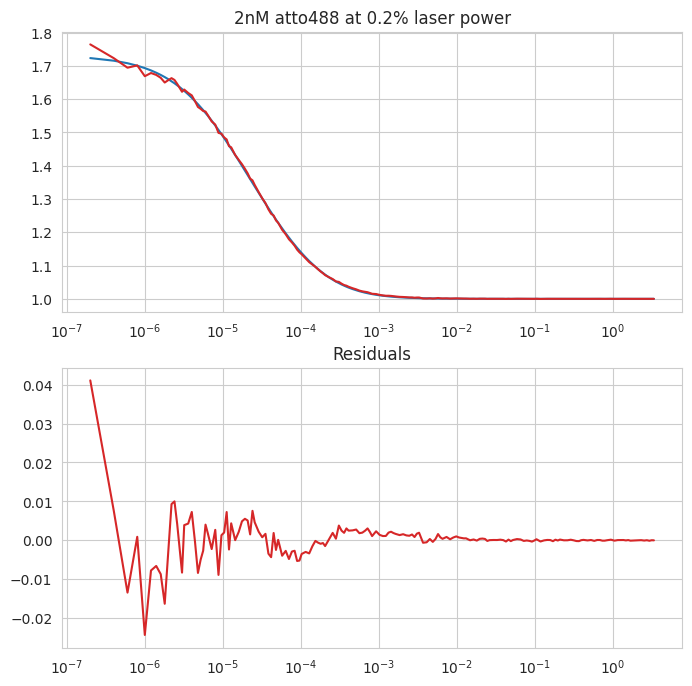

In [51]:
plot_fit(times_corr, mean_corr, two_comp)

In [44]:
def fcs_fit_params(times_corr, mean_corr, func, conc):
    fit = curve_fit(func, times_corr, mean_corr, p0=None)
    popt, pcov = fit
    N, tauD, K = popt
    C = conc
    w3 = N/(C*np.pi**(3/2)*K)
    w_by_conc = w3**(1./3)
    w_by_diff = tauD*4*400
    return w_by_conc, w_by_diff, tauD, K, N

In [49]:
w_by_conc, w_by_diff, tauD, K, N = fcs_fit_params(times_corr, mean_corr, f, 2)
print(w_by_conc, w_by_diff, tauD, K, N)

0.30991040885977367 0.2749615771891003 0.00017185098574318768 4.12910968710517 1.3687360737290173


/tmp/ipykernel_11813/336639674.py:2: RuntimeWarning: invalid value encountered in sqrt
  return 1 + (1/N) * (1/(1+tau/tauD)) * (1/(1+(tau/tauD)*(k**2)))**0.5


# Fit Ste20 data

In [55]:
ApSte20 = fcs.ConfoCor3Fcs('2024_02_01-FCS/ApSte20-GFP-withinBuds.fcs')

Instead of averaging, compute for each trace and plot all 5. 

In [56]:
data = ApSte20

In [57]:
times_corr = data['FcsData']['FcsEntry'][0]['FcsDataSet']['CorrelationArray'][:,0]
corr = data['FcsData']['FcsEntry'][4]['FcsDataSet']['CorrelationArray'][:,1]

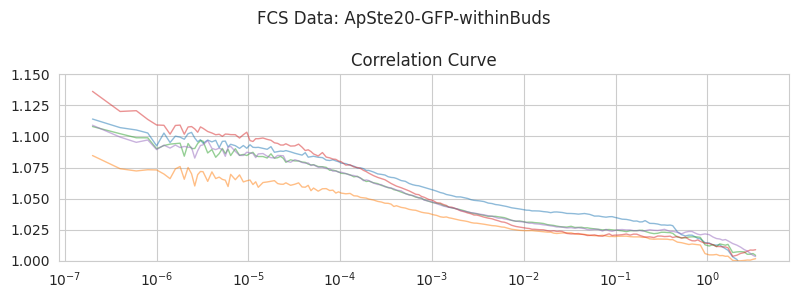

In [58]:
fig, axs = plt.subplots(1, 1, figsize=(8,3))
fig.suptitle(f'FCS Data: {data["FcsData"]["Name"]}')
axs.set_xscale("log")
axs.set_ylim([1,1.15])
for i in range(5):
    corr = data['FcsData']['FcsEntry'][i]['FcsDataSet']['CorrelationArray'][:,1]
    axs.plot(times_corr, corr, linewidth=1, alpha=0.5)
axs.set_title("Correlation Curve")
fig.tight_layout()

In [59]:
def plot_fit2(xdata, ydata, f, text="test"):
    fit = curve_fit(f, xdata, ydata, p0=None)
    popt, pcov = fit
    perr = np.sqrt(np.diag(pcov))
    fig, axs = plt.subplots(3, 1, figsize=(8,8))
    axs[0].plot(xdata, f(xdata, *popt))
    axs[0].set_xscale("log")
    axs[0].plot(xdata, ydata, color="C03")
    axs[0].set_title(f"{text}")
    residuals = ydata - f(xdata, *popt)
    axs[1].plot(xdata, residuals, color="C03")
    axs[1].set_xscale("log")
    axs[1].set_title(f"Residuals")
    axs[1].axhline(y = 0, linestyle = '-') 
    axs[2].bar([f"N={round(popt[0],3)}", f"tauD={round(popt[1],6)}"], [popt[0], popt[1]], yerr=perr)
    axs[2].set_yscale("log")
    fig.tight_layout()

[12.38099239  0.02647732]


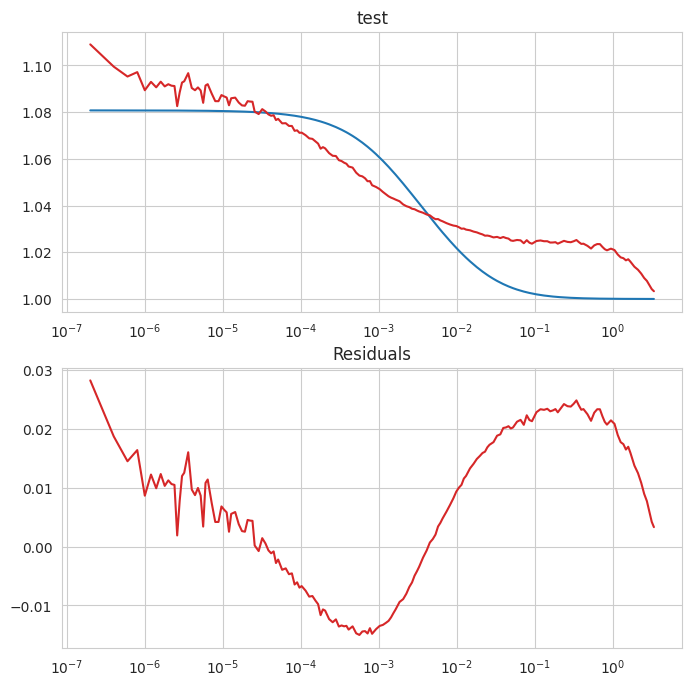

In [63]:
plot_fit(times_corr, corr, f=f, text="test")

In [109]:
fit = curve_fit(f, times_corr, corr, p0=None)
popt, pcov = fit
N, tauD= popt
K = 4.1
w = 0.275
D = (w**2) / (4*tauD)
C = N / (np.pi**(3/2)*K*w**3)
print(C, D)

26.076464552956946 0.7140544620842164


In [133]:
data  = fcs.ConfoCor3Fcs('2024_02_01-FCS/ApSte20-GFP-withinBuds.fcs')
K = 4.1
w = 0.275
Clist =[]
Dlist =[]
for i in range(5):
    corr = data['FcsData']['FcsEntry'][i]['FcsDataSet']['CorrelationArray'][:,1]
    fit = curve_fit(f, times_corr, corr, p0=None)
    popt, pcov = fit
    N, tauD= popt
    D = (w**2) / (4*tauD)
    C = N / (np.pi**(3/2)*K*w**3)
    Clist.append(C)
    Dlist.append(D)

In [179]:
times_corr[135]

0.1048576

# Any decay after 0.1 seconds is due to photobleaching or similar unwanted effect. Subtract it out. 

/tmp/ipykernel_11813/2641908949.py:3: RuntimeWarning: invalid value encountered in sqrt
  return 1 + (1/N) * (1/(1+tau/tauD)) * (1/(1+(tau/tauD)*(k**2)))**0.5


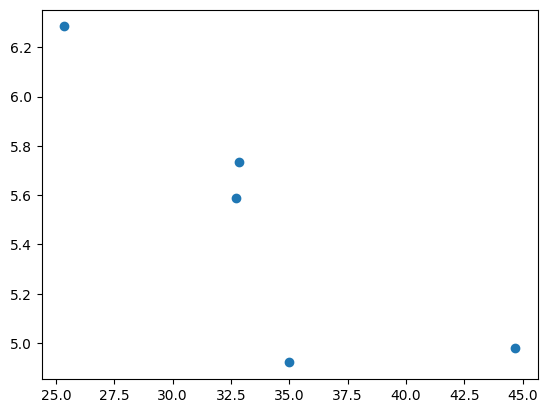

In [180]:
data  = fcs.ConfoCor3Fcs('2024_02_01-FCS/ApSte20-GFP-withinBuds.fcs')
K = 4.1
w = 0.275
Clist =[]
Dlist =[]
for i in range(5):
    corr = data['FcsData']['FcsEntry'][i]['FcsDataSet']['CorrelationArray'][:,1]
    corr = corr - corr[135] + 1
    fit = curve_fit(f, times_corr[:135], corr[:135], p0=None)
    popt, pcov = fit
    N, tauD= popt
    D = (w**2) / (4*tauD)
    C = N / (np.pi**(3/2)*K*w**3)
    Clist.append(C)
    Dlist.append(D)
plt.scatter(Clist, Dlist)

/tmp/ipykernel_11813/2641908949.py:3: RuntimeWarning: invalid value encountered in sqrt
  return 1 + (1/N) * (1/(1+tau/tauD)) * (1/(1+(tau/tauD)*(k**2)))**0.5


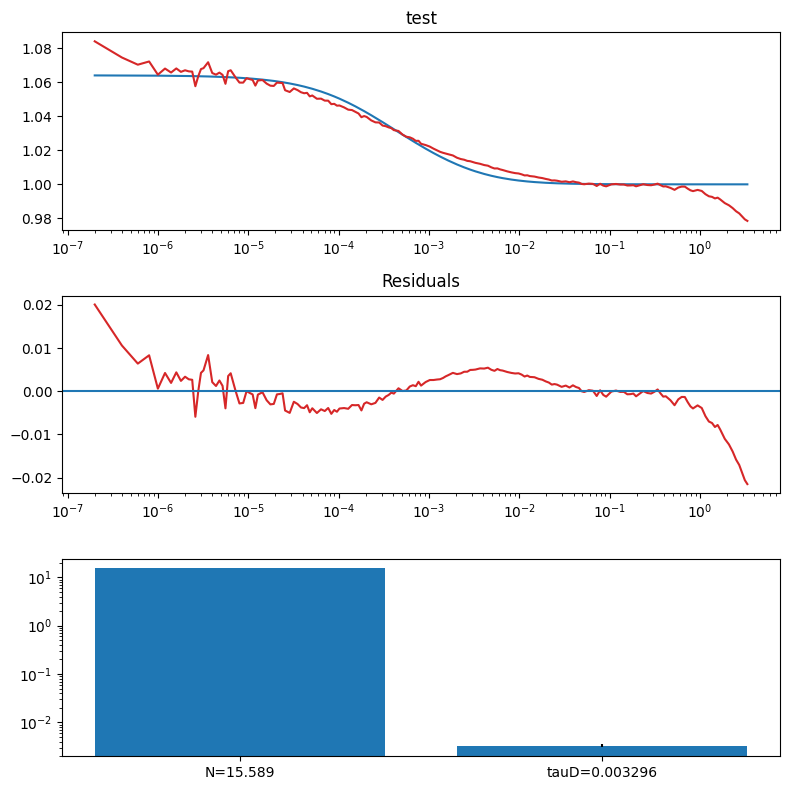

In [181]:
plot_fit2(times_corr, corr, f=f, text="test")

In [205]:
import os
for file in os.listdir("2024_02_01-FCS"):
    if file.endswith(".fcs"):
        if file.startswith("Ap"):
            species = "Ap"
        elif file.startswith("Sc"):
            species = "Sc"
        else:
            continue
        if "Ste20" in file:
            probe = "Ste20"
        elif "Cdc24" in file:
            probe = "Cdc24"
        elif "Bem1" in file:
            probe = "Bem1"
        else:
            print(f"unknown probe in {file}")
        
        
        

In [240]:
Ste20["Sc"]

[[11.463595954538905,
  14.531809435499662,
  13.60245625994986,
  16.402420898307636,
  15.127450687558671],
 [9.00429446813989, 11.841772598396256, 10.315142792354276, 13.35802772314216],
 [8.104340145142482,
  6.810197511264485,
  27.839987787521594,
  17.693371857126326,
  10.107667662786575]]

In [4]:
def get_CandD(file, K=4.1,w=0.275):
    data  = fcs.ConfoCor3Fcs(file)
    K = 4.1
    w = 0.275
    Clist =[]
    Dlist =[]
    for i in range(len(data['FcsData']['FcsEntry'])):
        corr = data['FcsData']['FcsEntry'][i]['FcsDataSet']['CorrelationArray'][:,1]
        corr = corr - corr[135] + 1
        fit = curve_fit(f, times_corr[:135], corr[:135], p0=None)
        popt, pcov = fit
        N, tauD= popt
        D = (w**2) / (4*tauD)
        C = N / (np.pi**(3/2)*K*w**3)
        Clist.append(C)
        Dlist.append(D)
    return Clist, Dlist

In [11]:
times_corr = data['FcsData']['FcsEntry'][0]['FcsDataSet']['CorrelationArray'][:,0]

ApSte20-GFP-mothers.fcs


/tmp/ipykernel_19339/2641908949.py:3: RuntimeWarning: invalid value encountered in sqrt
  return 1 + (1/N) * (1/(1+tau/tauD)) * (1/(1+(tau/tauD)*(k**2)))**0.5


ScCdc24-GFP-polarized.fcs
ApSte20-GFP-mother-and-5daughters.fcs


/tmp/ipykernel_19339/2641908949.py:3: RuntimeWarning: invalid value encountered in sqrt
  return 1 + (1/N) * (1/(1+tau/tauD)) * (1/(1+(tau/tauD)*(k**2)))**0.5


ApCdc24-GFP-mothers.fcs


/tmp/ipykernel_19339/2641908949.py:3: RuntimeWarning: invalid value encountered in sqrt
  return 1 + (1/N) * (1/(1+tau/tauD)) * (1/(1+(tau/tauD)*(k**2)))**0.5


ApBem1-GFP-mothers2.fcs
ApCdc24-GFP-yeasts.fcs
ApSte20-GFP-1polaritySite.fcs
ScSte20-GFP-withinBuds.fcs
ApSte20-GFP-unbudded-mononucleate.fcs
ScCdc24-GFP-growingBud.fcs
ScCdc24-GFP-unbudded.fcs
ScBem1-GFP-unbudded.fcs
ScSte20-GFP-polarizedCells.fcs
ScBem1-GFP-growingBuds.fcs
ApSte20-GFP-withinBuds.fcs


/tmp/ipykernel_19339/2641908949.py:3: RuntimeWarning: invalid value encountered in sqrt
  return 1 + (1/N) * (1/(1+tau/tauD)) * (1/(1+(tau/tauD)*(k**2)))**0.5


ApSte20-GFP-polarizedYeasts.fcs


/tmp/ipykernel_19339/2641908949.py:3: RuntimeWarning: invalid value encountered in sqrt
  return 1 + (1/N) * (1/(1+tau/tauD)) * (1/(1+(tau/tauD)*(k**2)))**0.5


ScSte20-GFP-unbudded.fcs


/tmp/ipykernel_19339/2641908949.py:3: RuntimeWarning: invalid value encountered in sqrt
  return 1 + (1/N) * (1/(1+tau/tauD)) * (1/(1+(tau/tauD)*(k**2)))**0.5


ApBem1-GFP-unbuddedYeast.fcs


/tmp/ipykernel_19339/2641908949.py:3: RuntimeWarning: invalid value encountered in sqrt
  return 1 + (1/N) * (1/(1+tau/tauD)) * (1/(1+(tau/tauD)*(k**2)))**0.5


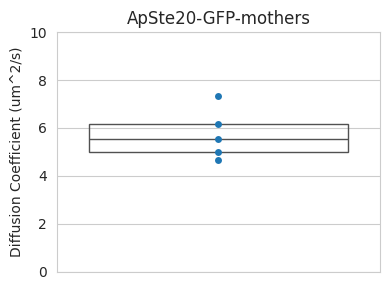

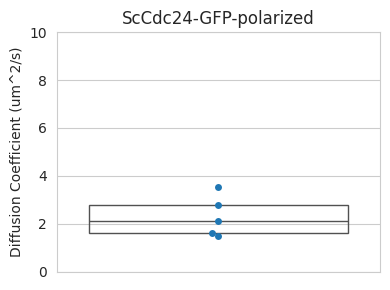

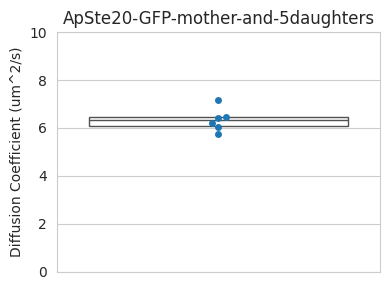

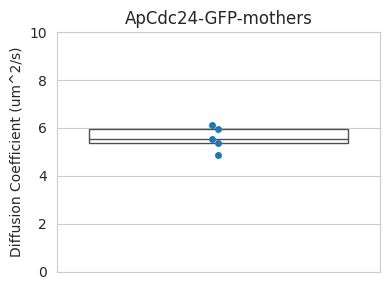

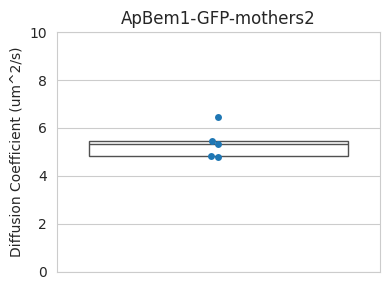

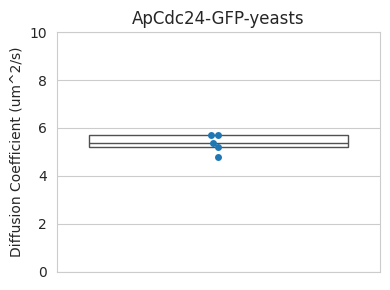

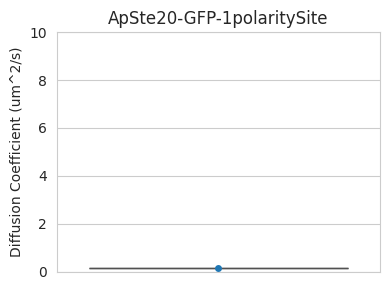

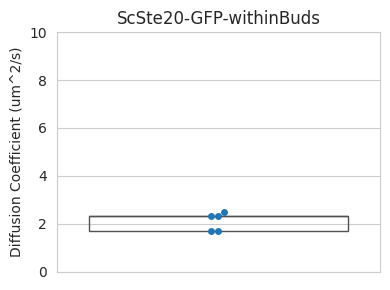

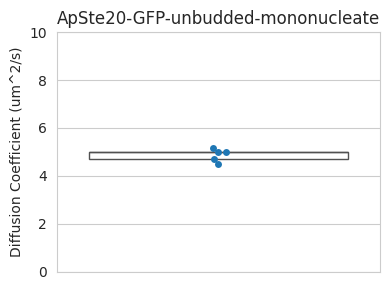

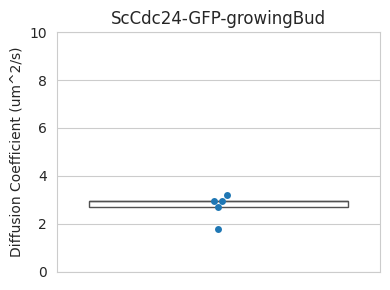

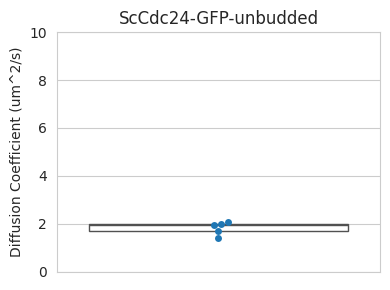

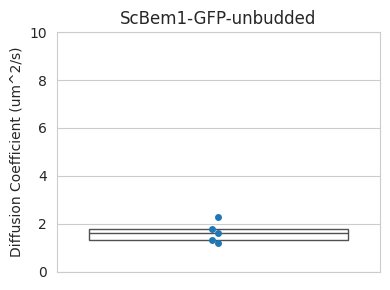

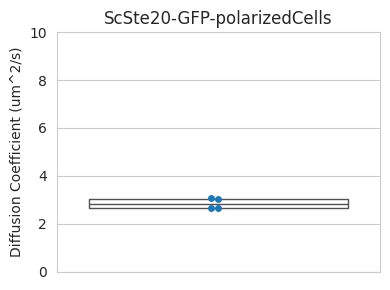

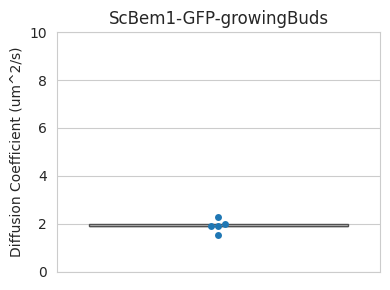

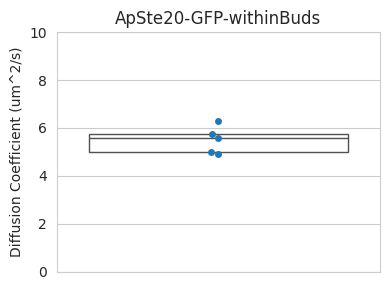

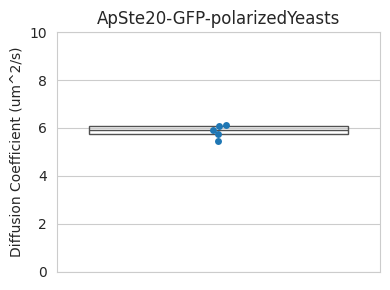

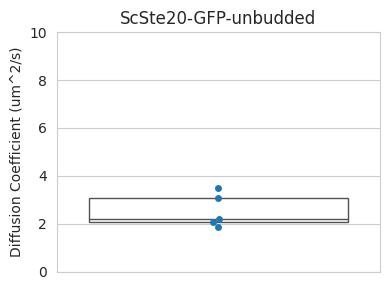

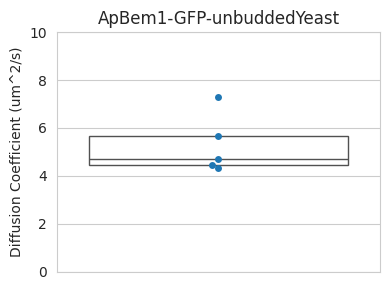

In [21]:
import os
import seaborn as sns
for file in os.listdir("2024_02_01-FCS"):
    if file.endswith(".fcs") and "GFP" in file:
        print(file)
        name = file.split(".")[0]
        C, D = get_CandD(f"2024_02_01-FCS/{file}")
        fig, axs = plt.subplots(1, 1, figsize=(4,3))
        sns.set_style("whitegrid")
        axs = sns.swarmplot(D)
        axs = sns.boxplot(D,
                showcaps=False,boxprops={'facecolor':'None'},
                showfliers=False,whiskerprops={'linewidth':0})
        axs.set_ylabel("Diffusion Coefficient (um^2/s)")
        axs.set_title(f"{name}")
        axs.set_ylim(0, 10)
        fig.tight_layout()
        plt.savefig(f"dfn_{name}.png")

/tmp/ipykernel_11813/2641908949.py:3: RuntimeWarning: invalid value encountered in sqrt
  return 1 + (1/N) * (1/(1+tau/tauD)) * (1/(1+(tau/tauD)*(k**2)))**0.5
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


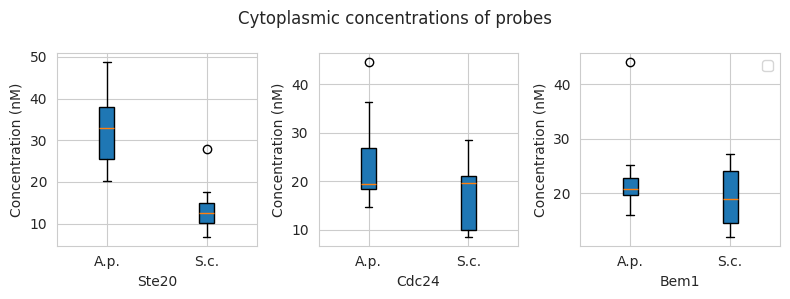

In [352]:
Ste20 = {"Ap":[],"Sc":[]}
Cdc24 = {"Ap":[],"Sc":[]}
Bem1 = {"Ap":[],"Sc":[]}
# Files for each fluor, species(, set)
import os
for file in os.listdir("2024_02_01-FCS"):
    if file.endswith(".fcs"):
        if file.startswith("Ap"):
            species = "Ap"
        elif file.startswith("Sc"):
            species = "Sc"
        else:
            continue
        C, D = get_CandD(f"2024_02_01-FCS/{file}")
        if "Ste20" in file:
            probe = "Ste20"
            Ste20[species].append(C)
        elif "Cdc24" in file:
            probe = "Cdc24"
            Cdc24[species].append(C)
        elif "Bem1" in file:
            probe = "Bem1"
            Bem1[species].append(C)
        else:
            print(f"unknown probe in {file}")
# Get C and D estimates

# Plot Ap cs Sc for each fluor. Color within category by set. 
labels = ["Ste20-GFP", "Cdc24-GFP", "Bem1-GFP"]
Sp = ["A.p.", "S.c."]
fig, axs = plt.subplots(1, 3, figsize=(8,3))

Ste20["Ap"] = sum(Ste20["Ap"], [])
Ste20["Sc"] = sum(Ste20["Sc"], [])
Cdc24["Ap"] = sum(Cdc24["Ap"], [])
Cdc24["Sc"] = sum(Cdc24["Sc"], [])
Bem1["Ap"] = sum(Bem1["Ap"], [])
Bem1["Sc"] = sum(Bem1["Sc"], [])

axs[0].boxplot([Ste20["Ap"],Ste20["Sc"]], labels=Sp, patch_artist = True)
axs[0].set_xlabel("Ste20")
axs[0].set_ylabel("Concentration (nM)")

axs[1].boxplot([Cdc24["Ap"],Cdc24["Sc"]], labels=Sp, patch_artist = True)
axs[1].set_xlabel("Cdc24")
axs[1].set_ylabel("Concentration (nM)")

axs[2].boxplot([Bem1["Ap"],Bem1["Sc"]], labels=Sp, patch_artist = True)
axs[2].set_xlabel("Bem1")
axs[2].set_ylabel("Concentration (nM)")

fig.suptitle("Cytoplasmic concentrations of probes")
plt.legend()
plt.tight_layout()

In [286]:
import seaborn as sns

Text(0.5, 1.0, 'Ste20 concentration in cytoplasm')

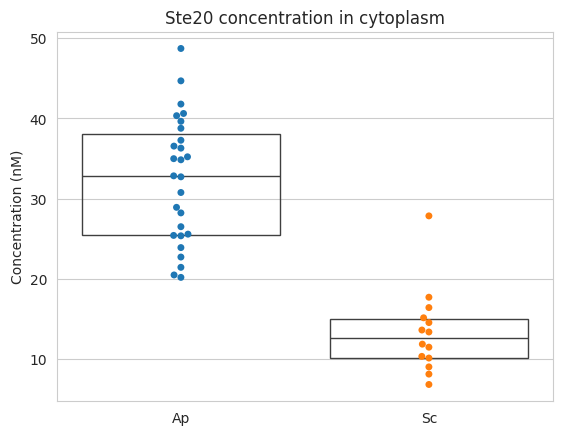

In [353]:
sns.set_style("whitegrid")
ax = sns.swarmplot(Ste20)
ax = sns.boxplot(Ste20,
        showcaps=False,boxprops={'facecolor':'None'},
        showfliers=False,whiskerprops={'linewidth':0})
ax.set_ylabel("Concentration (nM)")
ax.set_title("Ste20 concentration in cytoplasm")

/tmp/ipykernel_11813/2641908949.py:3: RuntimeWarning: invalid value encountered in sqrt
  return 1 + (1/N) * (1/(1+tau/tauD)) * (1/(1+(tau/tauD)*(k**2)))**0.5
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


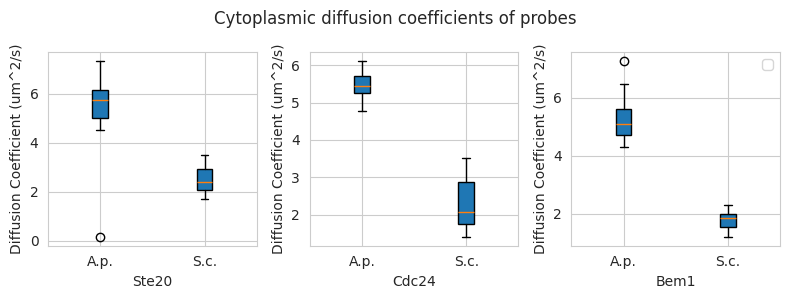

In [351]:
Ste20 = {"Ap":[],"Sc":[]}
Cdc24 = {"Ap":[],"Sc":[]}
Bem1 = {"Ap":[],"Sc":[]}
# Files for each fluor, species(, set)
import os
for file in os.listdir("2024_02_01-FCS"):
    if file.endswith(".fcs"):
        if file.startswith("Ap"):
            species = "Ap"
        elif file.startswith("Sc"):
            species = "Sc"
        else:
            continue
        C, D = get_CandD(f"2024_02_01-FCS/{file}")
        if "Ste20" in file:
            probe = "Ste20"
            Ste20[species].append(D)
        elif "Cdc24" in file:
            probe = "Cdc24"
            Cdc24[species].append(D)
        elif "Bem1" in file:
            probe = "Bem1"
            Bem1[species].append(D)
        else:
            print(f"unknown probe in {file}")
# Get C and D estimates

# Plot Ap cs Sc for each fluor. Color within category by set. 
labels = ["Ste20-GFP", "Cdc24-GFP", "Bem1-GFP"]
Sp = ["A.p.", "S.c."]
fig, axs = plt.subplots(1, 3, figsize=(8,3))

Ste20["Ap"] = sum(Ste20["Ap"], [])
Ste20["Sc"] = sum(Ste20["Sc"], [])
Cdc24["Ap"] = sum(Cdc24["Ap"], [])
Cdc24["Sc"] = sum(Cdc24["Sc"], [])
Bem1["Ap"] = sum(Bem1["Ap"], [])
Bem1["Sc"] = sum(Bem1["Sc"], [])

axs[0].boxplot([Ste20["Ap"],Ste20["Sc"]], labels=Sp, patch_artist = True)
axs[0].set_xlabel("Ste20")
axs[0].set_ylabel("Diffusion Coefficient (um^2/s)")

axs[1].boxplot([Cdc24["Ap"],Cdc24["Sc"]], labels=Sp, patch_artist = True)
axs[1].set_xlabel("Cdc24")
axs[1].set_ylabel("Diffusion Coefficient (um^2/s)")

axs[2].boxplot([Bem1["Ap"],Bem1["Sc"]], labels=Sp, patch_artist = True)
axs[2].set_xlabel("Bem1")
axs[2].set_ylabel("Diffusion Coefficient (um^2/s)")

fig.suptitle("Cytoplasmic diffusion coefficients of probes")
plt.legend()
plt.tight_layout()

Text(0.5, 1.0, 'Ste20 concentration in cytoplasm')

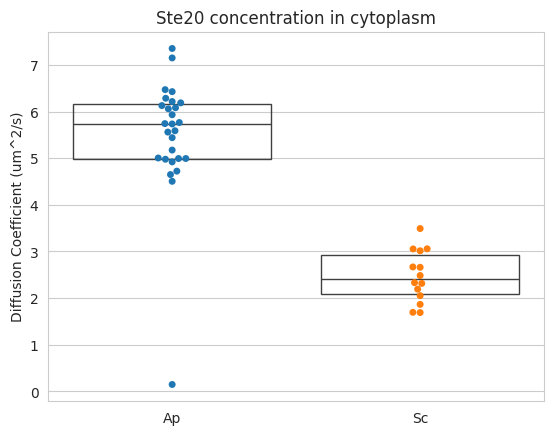

In [350]:
sns.set_style("whitegrid")
ax = sns.swarmplot(Ste20)
ax = sns.boxplot(Ste20,
        showcaps=False,boxprops={'facecolor':'None'},
        showfliers=False,whiskerprops={'linewidth':0})
ax.set_ylabel("Diffusion Coefficient (um^2/s)")
ax.set_title("Ste20 concentration in cytoplasm")

/tmp/ipykernel_11813/2641908949.py:3: RuntimeWarning: invalid value encountered in sqrt
  return 1 + (1/N) * (1/(1+tau/tauD)) * (1/(1+(tau/tauD)*(k**2)))**0.5


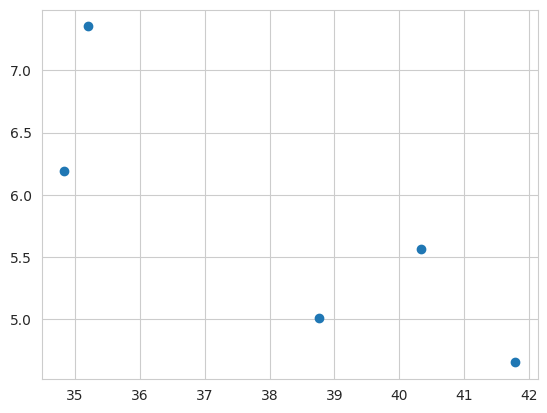

In [332]:
data = fcs.ConfoCor3Fcs('2024_02_01-FCS/ApSte20-GFP-mothers.fcs')
K = 4.1
w = 0.275
Clist = []
Dlist = []
for i in range(5):
    corr = data['FcsData']['FcsEntry'][i]['FcsDataSet']['CorrelationArray'][:,1]
    corr = corr - corr[135] + 1
    fit = curve_fit(f, times_corr, corr, p0=None)
    popt, pcov = fit
    N, tauD= popt
    D = (w**2) / (4*tauD)
    C = N / (np.pi**(3/2)*K*w**3)
    Clist.append(C)
    Dlist.append(D)
plt.scatter(Clist, Dlist)

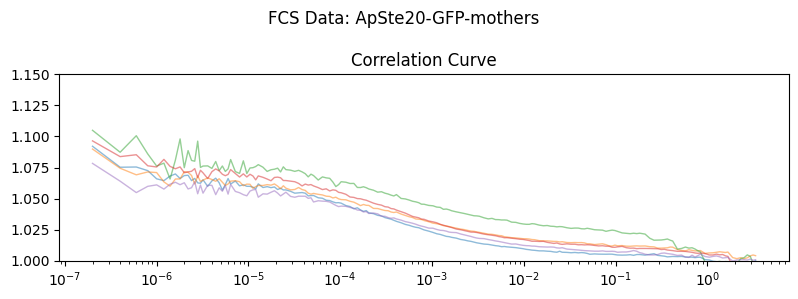

In [144]:
fig, axs = plt.subplots(1, 1, figsize=(8,3))
fig.suptitle(f'FCS Data: {data["FcsData"]["Name"]}')
axs.set_xscale("log")
axs.set_ylim([1,1.15])
for i in range(5):
    corr = data['FcsData']['FcsEntry'][i]['FcsDataSet']['CorrelationArray'][:,1]
    axs.plot(times_corr, corr, linewidth=1, alpha=0.5)
axs.set_title("Correlation Curve")
fig.tight_layout()

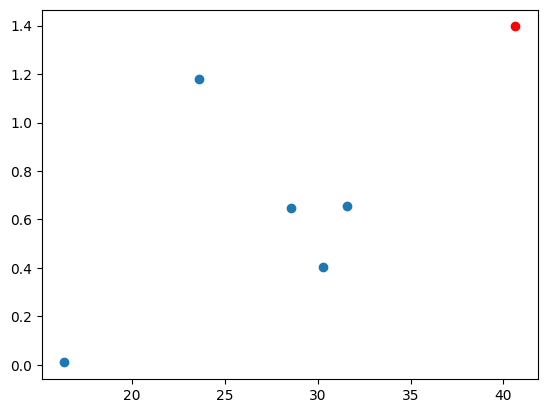

In [136]:
data = fcs.ConfoCor3Fcs('2024_02_01-FCS/ApSte20-GFP-mother-and-5daughters.fcs')
K = 4.1
w = 0.275
Clist = []
Dlist = []
for i in range(6):
    corr = data['FcsData']['FcsEntry'][i]['FcsDataSet']['CorrelationArray'][:,1]
    fit = curve_fit(f, times_corr, corr, p0=None)
    popt, pcov = fit
    N, tauD= popt
    D = (w**2) / (4*tauD)
    C = N / (np.pi**(3/2)*K*w**3)
    Clist.append(C)
    Dlist.append(D)
plt.scatter(Clist[0], Dlist[0], c="r")
plt.scatter(Clist[1:], Dlist[1:])

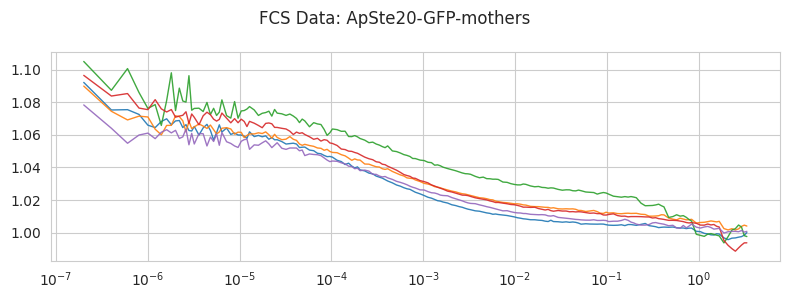

In [335]:
fig, axs = plt.subplots(1, 1, figsize=(8,3))
fig.suptitle(f'FCS Data: {data["FcsData"]["Name"]}')
axs.set_xscale("log")
for i in range(5):
    corr = data['FcsData']['FcsEntry'][i]['FcsDataSet']['CorrelationArray'][:,1]
    axs.plot(times_corr, corr, linewidth=1, alpha=0.9)
fig.tight_layout()

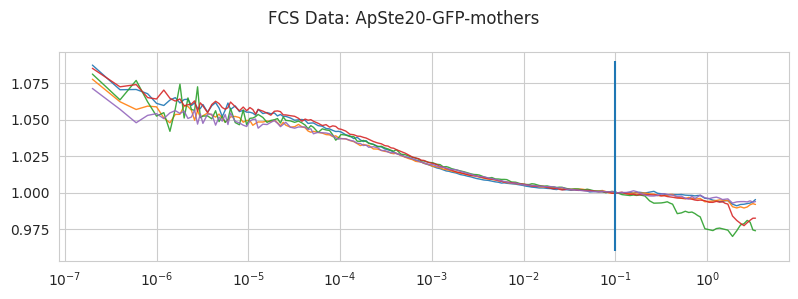

In [334]:
fig, axs = plt.subplots(1, 1, figsize=(8,3))
fig.suptitle(f'FCS Data: {data["FcsData"]["Name"]}')
axs.set_xscale("log")
for i in range(5):
    corr = data['FcsData']['FcsEntry'][i]['FcsDataSet']['CorrelationArray'][:,1]
    corr = corr - corr[135] + 1
    axs.plot(times_corr, corr, linewidth=1, alpha=0.9)
axs.vlines(0.1, .96,1.09)
fig.tight_layout()

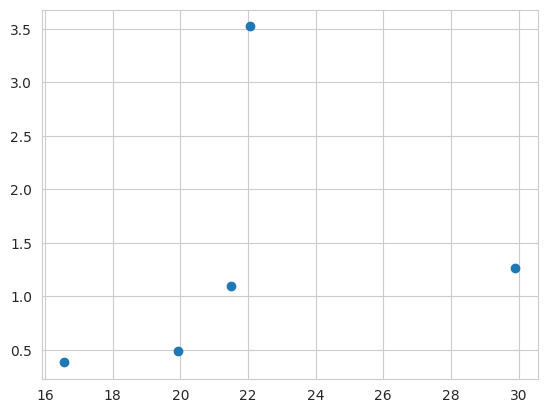

In [323]:
data = fcs.ConfoCor3Fcs('2024_02_01-FCS/ApSte20-GFP-polarizedYeasts.fcs')
K = 4.1
w = 0.275
Clist = []
Dlist = []
for i in range(5):
    corr = data['FcsData']['FcsEntry'][i]['FcsDataSet']['CorrelationArray'][:,1]
    fit = curve_fit(f, times_corr, corr, p0=None)
    popt, pcov = fit
    N, tauD= popt
    D = (w**2) / (4*tauD)
    C = N / (np.pi**(3/2)*K*w**3)
    Clist.append(C)
    Dlist.append(D)
plt.scatter(Clist, Dlist)

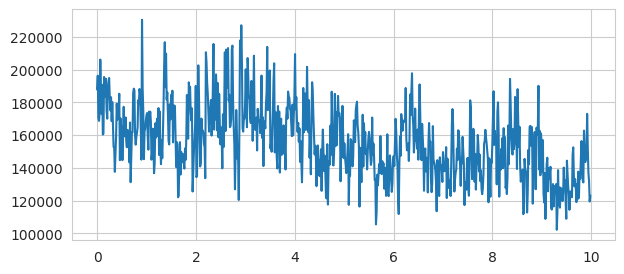

In [348]:
fig, axs = plt.subplots(1, 1, figsize=(7,3))
counts = data['FcsData']['FcsEntry'][4]['FcsDataSet']['CountRateArray'][:,1]
axs.plot(times_counts, counts)

In [337]:
b, a = signal.butter(4, 100, 'high')
w, h = signal.freqs(b, a)
plt.semilogx(w, 20 * np.log10(abs(h)))
plt.title('Butterworth filter frequency response')
plt.xlabel('Frequency [radians / second]')
plt.ylabel('Amplitude [dB]')
plt.margins(0, 0.1)
plt.grid(which='both', axis='both')
plt.axvline(100, color='green') # cutoff frequency
plt.show()

ValueError: Digital filter critical frequencies must be 0 < Wn < 1